In [1]:
!pip install torch_snippets
from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

max_iters = 500

     |████████████████████████████████| 61kB 2.3MB/s 
     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 204kB 11.0MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 


2021-06-09 17:50:16.248 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-06-09 17:50:16.898 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [2]:
from torchvision.models import vgg19
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])
postprocess = T.Compose([
    T.Lambda(lambda x: x/255),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])

In [3]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b, c, h*w)
        G = feat@feat.transpose(1,2)
        G.div_(h*w)
        return G
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval() 
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix,model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x


In [4]:
vgg = vgg19_modified().to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


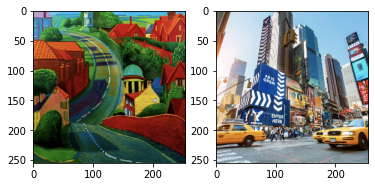

In [5]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread('style.png')
im2 = cv2.imread('content.png')
im_resized = cv2.resize(im, (255, 255), interpolation=cv2.INTER_LINEAR)
im_resized2 = cv2.resize(im2, (255, 255), interpolation=cv2.INTER_LINEAR)

plt.subplot(121)
plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.imshow(cv2.cvtColor(im_resized2, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['style.png', 'content.png']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

# Five Layers Training

In [7]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

In [8]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [21]
loss_layers = style_layers + content_layers

In [9]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [10]:
style_weights = [1000/n**2 for n in [64,128,256,512,512]]
content_weights = [1]
weights = style_weights + content_weights

In [11]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [12]:
optimizer = optim.LBFGS([opt_img])
log = Report(max_iters)

In [13]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 502.000	loss: 582095.500	(83.55s - -0.33s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


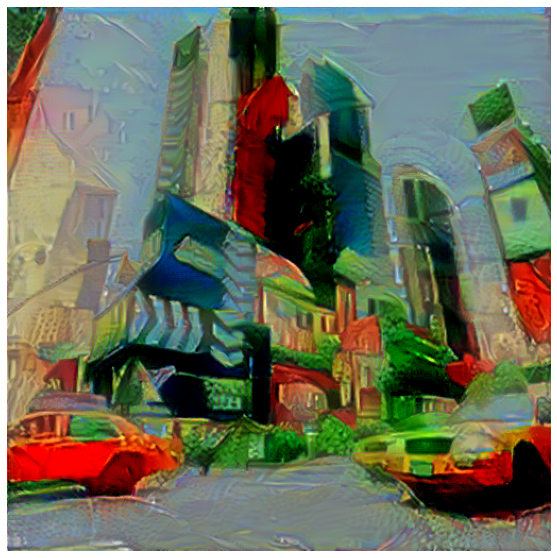

In [14]:
out_img = postprocess(opt_img[0]).permute(1,2,0)
show(out_img)

# Substract First Two Layers

In [15]:
opt_img_v1 = content_image.data.clone()
opt_img_v1.requires_grad = True

In [16]:
style_layers_v1 = [10, 19, 28]
loss_fns = [GramMSELoss()] * len(style_layers_v1) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]
style_weights_v1 = [1000/n**2 for n in [256,512,512]]
loss_layers_v1 = style_layers_v1 + content_layers

In [17]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers_v1)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets
weights_v1 = style_weights_v1 + content_weights

In [18]:
optimizer = optim.LBFGS([opt_img_v1])
log = Report(max_iters)

In [19]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img_v1, loss_layers_v1)
        layer_losses = [weights_v1[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 500.000	loss: 490600.500	(73.47s - 0.00s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


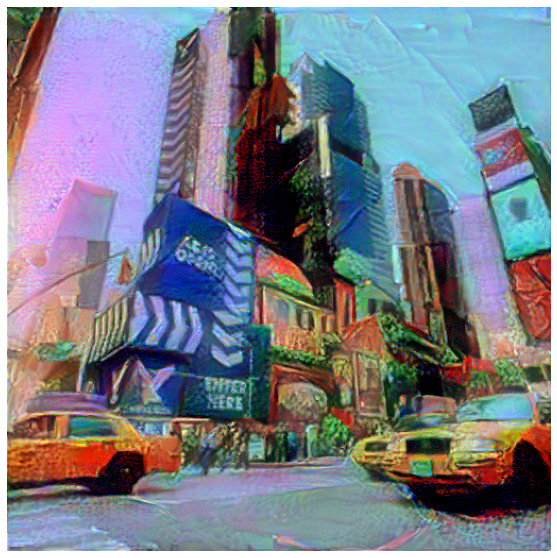

In [20]:
out_img = postprocess(opt_img_v1[0]).permute(1,2,0)
show(out_img)

# Substract Last Two Layers

In [21]:
opt_img_v2 = content_image.data.clone()
opt_img_v2.requires_grad = True

In [22]:
style_layers_v2 = [0, 5, 10]
loss_fns = [GramMSELoss()] * len(style_layers_v2) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]
style_weights_v2 = [1000/n**2 for n in [64,128,256]]
loss_layers_v2 = style_layers_v2 + content_layers

In [23]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers_v2)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets
weights_v2 = style_weights_v2 + content_weights

In [24]:
optimizer = optim.LBFGS([opt_img_v2])
log = Report(max_iters)

In [25]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img_v2, loss_layers_v2)
        layer_losses = [weights_v2[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 502.000	loss: 263357.438	(79.61s - -0.32s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


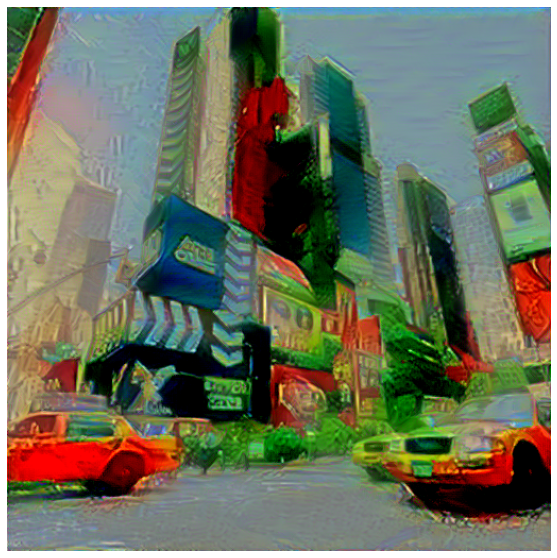

In [26]:
out_img = postprocess(opt_img_v2[0]).permute(1,2,0)
show(out_img)

# Second Hightest Solution

In [27]:
opt_img_v3 = content_image.data.clone()
opt_img_v3.requires_grad = True

In [28]:
style_layers_v3 = [2, 3]
loss_fns = [GramMSELoss()] * len(style_layers_v3) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]
style_weights_v3 = [1000/n**2 for n in [64, 64]]
loss_layers_v3 = style_layers_v3 + content_layers

In [29]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers_v3)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets
weights_v3 = style_weights_v3 + content_weights

In [30]:
optimizer = optim.LBFGS([opt_img_v3])
log = Report(max_iters)

In [31]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img_v3, loss_layers_v3)
        layer_losses = [weights_v3[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 502.000	loss: 27631.477	(80.42s - -0.32s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


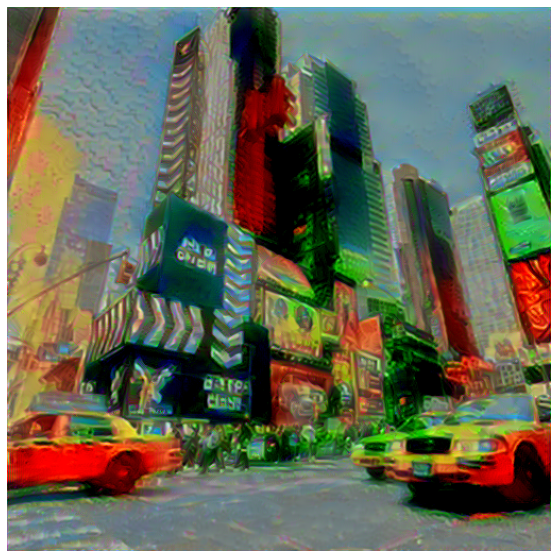

In [32]:
out_img = postprocess(opt_img_v3[0]).permute(1,2,0)
show(out_img)